# Import the libraries

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import glob
import zipfile

## 1. Load Images

In [3]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip') as z:
    z.extractall('.')

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip') as z:
    z.extractall('.')

!ls /kaggle/working/

__notebook_source__.ipynb  test1  train


In [4]:
glob.glob('/kaggle/working/train/*.jpg')[:5]

['/kaggle/working/train/dog.7190.jpg',
 '/kaggle/working/train/dog.3191.jpg',
 '/kaggle/working/train/dog.5942.jpg',
 '/kaggle/working/train/cat.11251.jpg',
 '/kaggle/working/train/cat.9841.jpg']

### Create DataFrame

In [5]:
train_files= glob.glob('/kaggle/working/train/*.jpg')
train_labels = [i.strip('/kaggle/working/train/')[:3] for i in train_files]

train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})

In [6]:
train_df.head()

,filename,class
0,/kaggle/working/train/dog.7190.jpg,dog
1,/kaggle/working/train/dog.3191.jpg,dog
2,/kaggle/working/train/dog.5942.jpg,dog
3,/kaggle/working/train/cat.11251.jpg,cat
4,/kaggle/working/train/cat.9841.jpg,cat


In [7]:
train_df.shape

(25000, 2)

## 2. Look at the image

In [8]:
train_df['filename'][2]

'/kaggle/working/train/dog.5942.jpg'

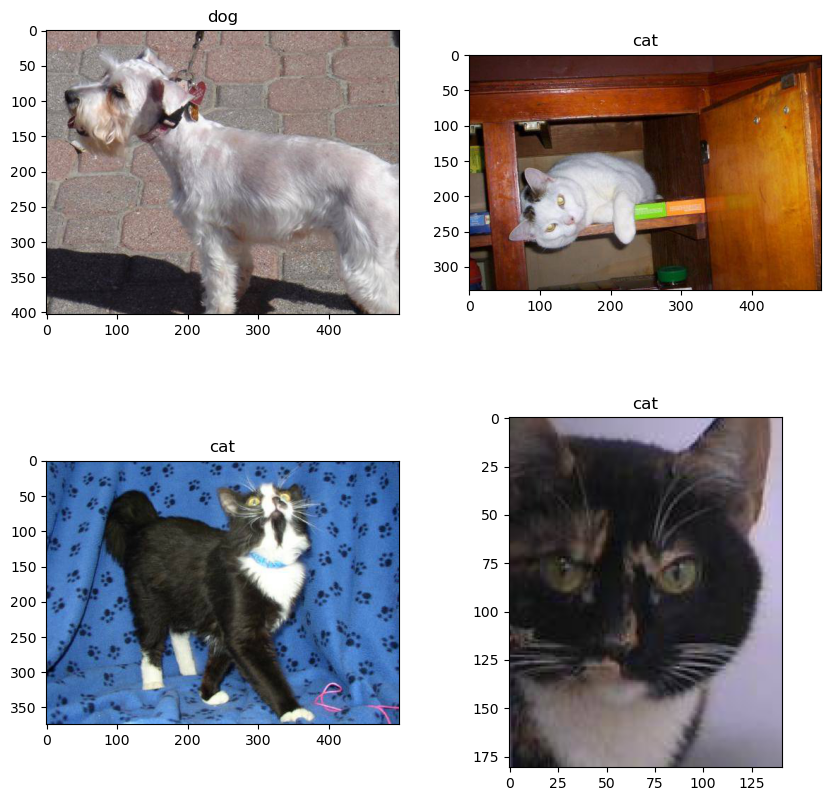

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(train_df.index)
    axs[i].imshow(Image.open(train_df['filename'][idx]))
    axs[i].set_title(train_df['class'][idx])

## 3. Built the loader.

In [11]:
train_datagen = ImageDataGenerator(rotation_range=5,
                                   rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2)

img_height, img_width = 224, 224
batch_size = 64
                               

In [12]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='categorical',
                                subset='training')

validation_generator = train_datagen.flow_from_dataframe(train_df,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='categorical',
                                subset='validation')
print('Class Indices:', train_generator.class_indices)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Class Indices: {'cat': 0, 'dog': 1}


## 4. Define a model

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2 ,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

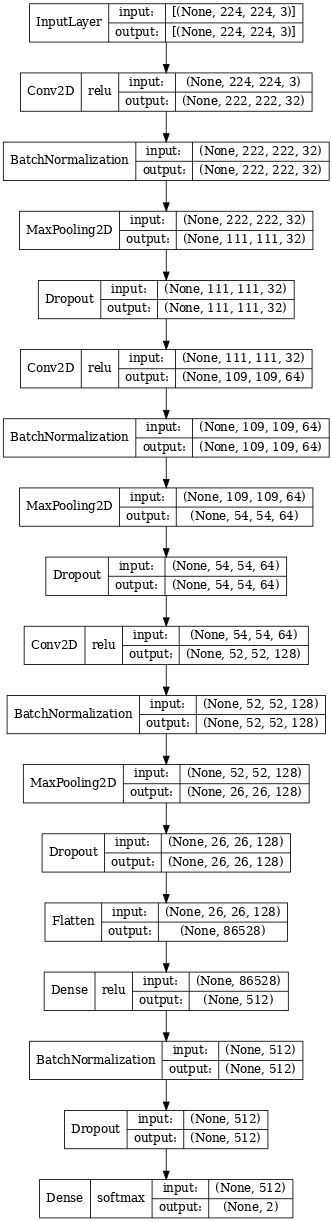

In [20]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60, show_layer_activations=True, rankdir='TB')

In [21]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [22]:
epochs = 10
history = model.fit(train_generator,
                   epochs=epochs,
                   validation_data=validation_generator)

Epoch 1/10


2023-03-14 11:18:53.759342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 360s 1s/step - loss: 0.8000 - accuracy: 0.6192 - val_loss: 0.7114 - val_accuracy: 0.5926
Epoch 2/10
313/313 [==============================] - 346s 1s/step - loss: 0.5715 - accuracy: 0.7007 - val_loss: 0.6413 - val_accuracy: 0.6398
Epoch 3/10
313/313 [==============================] - 344s 1s/step - loss: 0.5198 - accuracy: 0.7413 - val_loss: 0.5265 - val_accuracy: 0.7318
Epoch 4/10
313/313 [==============================] - 338s 1s/step - loss: 0.4719 - accuracy: 0.7727 - val_loss: 0.4509 - val_accuracy: 0.7944
Epoch 5/10
313/313 [==============================] - 336s 1s/step - loss: 0.4310 - accuracy: 0.7997 - val_loss: 0.9727 - val_accuracy: 0.6354
Epoch 6/10
313/313 [==============================] - 330s 1s/step - loss: 0.4190 - accuracy: 0.8074 - val_loss: 0.6763 - val_accuracy: 0.7034
Epoch 7/10
313/313 [==============================] - 335s 1s/step - loss: 0.4035 - accuracy: 0.8148 - val_loss: 0.3923 - val_accuracy: 0.8186
Epoch 8/10

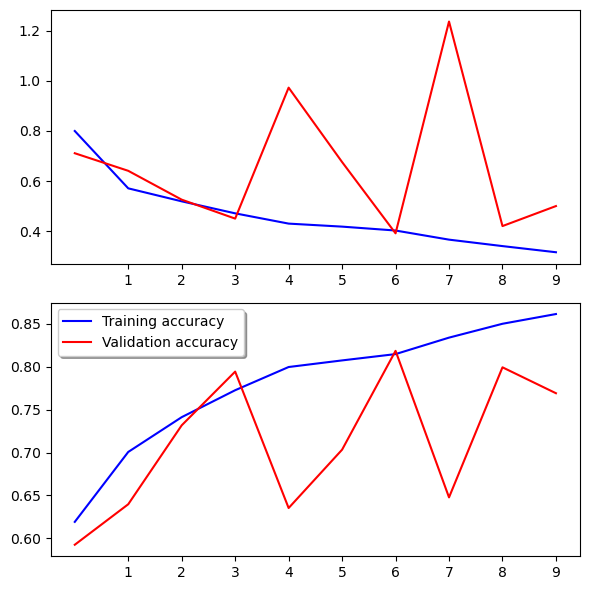

In [25]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    
    ax1.plot(history.history['loss'], color='b', label='Training loss')
    ax1.plot(history.history['val_loss'], color='r', label='Validation loss')
    ax1.set_xticks(np.arange(1, epochs, 1))
    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    
    
    ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
    ax2.set_xticks(np.arange(1, epochs, 1))
    
    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

plot_loss(history)

## 6. Get the predictions

In [26]:
test_files = glob.glob('/kaggle/working/test1/*.jpg')
test_df = pd.DataFrame({'filename': test_files})
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df,
                                             x_col='filename',
                                             y_col=None,
                                             class_mode=None,
                                        target_size=(img_height,img_width),
                                             batch_size = batch_size,
                                             shuffle=False)

Found 12500 validated image filenames.


2/2 [==============================] - 0s 14ms/step


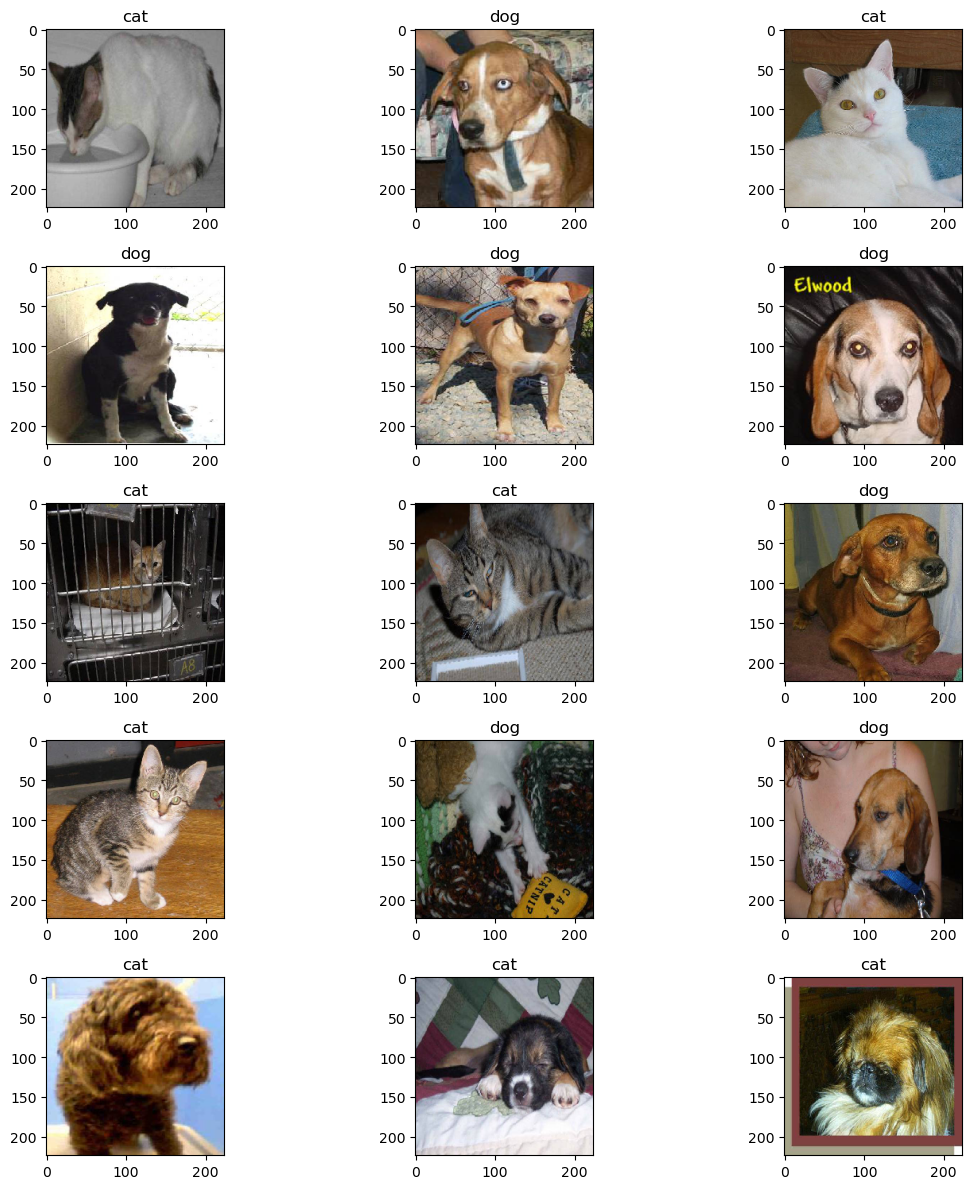

In [27]:
def visualize_predictions(test_generator, model):
    plt.figure(figsize=(12,12))
    for i in range(0, 15):
        plt.subplot(5, 3, i+1)
        for X_batch in test_generator:
            prediction = model.predict(X_batch)[0]
            image = X_batch[0]
            plt.imshow(image)
            plt.title('cat' if np.argmax(prediction)==0 else 'dog')
            break
    plt.tight_layout()
    plt.show()
    
visualize_predictions(test_generator, model)

## Transfer Learning

In [29]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import Input
from tensorflow.keras.models import Model

basemodel = Xception(include_top = False,
                    weights = 'imagenet',
                    input_shape=(img_height, img_width, 3))

basemodel.trainable = False

headModel = basemodel.output
headModel = MaxPooling2D(pool_size=(5,5))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.8)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=basemodel.input, outputs=headModel )

83683744/83683744 [==============================] - 4s 0us/step


In [30]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [31]:
epochs = 5
history = model.fit_generator(train_generator,
                             epochs=epochs,
                             validation_data=validation_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/5
313/313 [==============================] - 336s 1s/step - loss: 0.1255 - accuracy: 0.9617 - val_loss: 0.0455 - val_accuracy: 0.9848
Epoch 2/5
313/313 [==============================] - 339s 1s/step - loss: 0.0739 - accuracy: 0.9757 - val_loss: 0.0401 - val_accuracy: 0.9856
Epoch 3/5
313/313 [==============================] - 336s 1s/step - loss: 0.0680 - accuracy: 0.9771 - val_loss: 0.0452 - val_accuracy: 0.9848
Epoch 4/5
313/313 [==============================] - 337s 1s/step - loss: 0.0632 - accuracy: 0.9791 - val_loss: 0.0415 - val_accuracy: 0.9844
Epoch 5/5
313/313 [==============================] - 338s 1s/step - loss: 0.0587 - accuracy: 0.9804 - val_loss: 0.0422 - val_accuracy: 0.9860


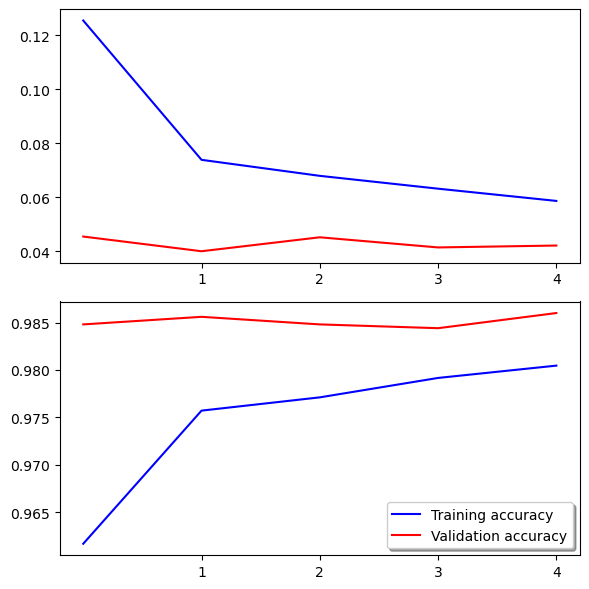

In [32]:
plot_loss(history)

2/2 [==============================] - 0s 72ms/step


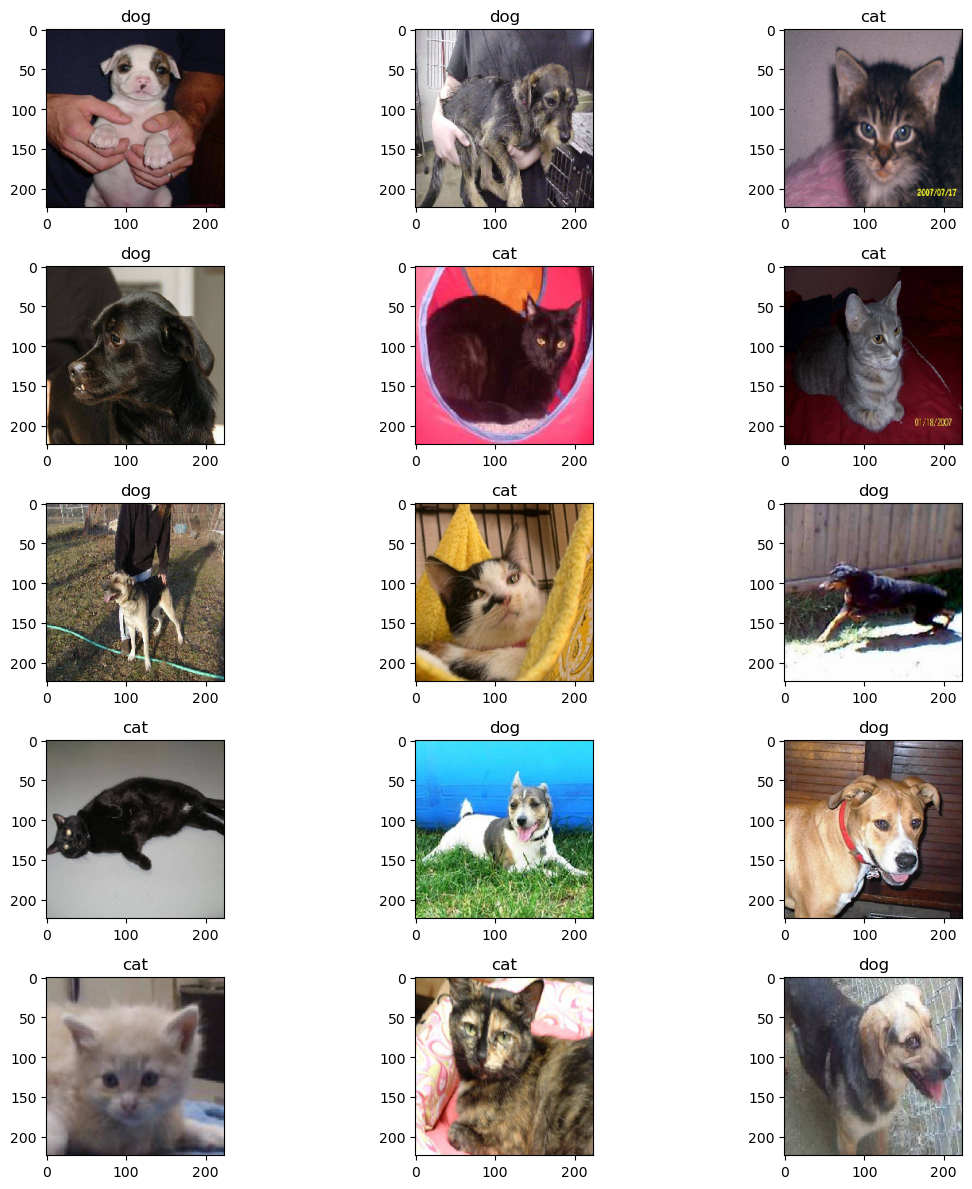

In [33]:
visualize_predictions(test_generator,model)

In [177]:
predictions = [np.argmax(i) for i in model.predict(test_generator)]
ids = [i+1 for i in test_df.index]

196/196 [==============================] - 56s 286ms/step


In [164]:
result = pd.DataFrame(columns=['id','label'])
result['id'] = ids
result['label'] = predictions

In [167]:
result.to_csv('/kaggle/working/submission.csv', index=False)